In [1]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import copy
#[173, 137, 34, 159, 201] #1
#[34, 202, 80, 135, 24] #2
# [173, 202, 130, 124, 125]#3
all_class=[[173, 137, 34, 159, 201],
           [34, 202, 80, 135, 24],
           [173, 202, 130, 124, 125]]

selected_classes=sum(all_class, [])
label_mapping = {}
label_idx = 0
for st in all_class:
    for orig_label in st:
        label_mapping[orig_label] = label_idx
        label_idx += 1
#print(label_mapping)

upper_map={
0:10,
2:5,
6:11
}

def load_data(file_path):
    raw_data = torch.load(file_path)
    data = raw_data['data']  
    labels = raw_data['labels']    
    if data.ndim == 4 and data.shape[-1] == 3:  
        data = data.permute(0, 3, 1, 2)  
    mapped_labels = torch.tensor([label_mapping[label.item()] for label in labels], dtype=torch.long)
    return TensorDataset(data, mapped_labels)

def load_mutifile_data(file_paths):
    all_data = []
    all_labels = []
    
    for file_path in file_paths:
        raw_data = torch.load(file_path)
        data = raw_data['data'] 
        labels = raw_data['labels'] 
        
        if data.ndim == 4 and data.shape[-1] == 3:  
            data = data.permute(0, 3, 1, 2) 
        #data = data.float() / 255.0
        #normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        #normalized_data = normalize(data)
 
        mapped_labels = torch.tensor([label_mapping[label.item()] for label in labels], dtype=torch.long)
        
      
        all_data.append(data)
        all_labels.append(mapped_labels)
    
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    

    return TensorDataset(all_data, all_labels)


bt_size=32

test_file_paths = [
    'data/Task2_data/val_dataB_model_1.pth',
    'data/Task2_data/val_dataB_model_2.pth',
    'data/Task2_data/val_dataB_model_3.pth'
]
test_set=load_mutifile_data(test_file_paths)


test_loader = DataLoader(test_set, batch_size=bt_size, shuffle=False, num_workers=4)

print('Finish data loading')
#print(f"Training data size: {len(train_set)}")
print(f"Testing data size: {len(test_set)}")


Finish data loading
Testing data size: 750


In [2]:
class CNN_0(nn.Module):
    def __init__(self):
        super(CNN_0, self).__init__()
        
        # Bloc 1 : Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloc 2 : Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Bloc 3 : Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Bloc 4 : Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 256)
        #self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(256, 5)  
        
   
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # Bloc 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Bloc 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Bloc 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Bloc 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        

        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
class MetaModel(nn.Module):
    def __init__(self, input_dim=15, hidden_dim1=128, hidden_dim2=64, num_classes=15):
        super(MetaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
from transformers import ViTForImageClassification,SwinForImageClassification
def create_filter_list_vit(file_list,device):
    """
    load the filter model from file pathes 
    """
    result=[]
    for f in file_list:
        model = ViTForImageClassification.from_pretrained(f,num_labels=3)
        model.to(device)
        model.eval()
        result.append(model)
    return result
def create_filter_list_swin(file_list,device):
    """
    load the filter model from file pathes 
    """
    result=[]
    for f in file_list:
        model = SwinForImageClassification.from_pretrained(f,num_labels=3)
        model.to(device)
        model.eval()
        result.append(model)
    return result
def create_classifier_list(file_list,device):
    result=[]
    # load classifiers
    for f in file_list:
        model =CNN_0() # 
        model.load_state_dict(torch.load(f))
        model.to(device)
        model.eval()
        result.append(model)
    return result
        



In [4]:
from transformers import SwinForImageClassification
def classifier_result(model,input_tensor,classifier_num):
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, dim=1)
        result=classifier_num*5+predicted_class.item()
        if result in upper_map:
            result=upper_map[result] # deal with label overlap
        return result
    

def merged_model(input_tensor, classifier_list, filter_model_list):
    """
    geive the prediction of input image using 3 classifiers and a 
    model to decide which classifier to chose
    """
    normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    op=input_tensor.float()/255.0
    nor_inputs = normalize(op)
    filter_tensor = torchvision.transforms.functional.resize(nor_inputs, (224, 224))
    
    #print(filter_tensor)
    pre_set=set()
    result=[]
    n=len(filter_model_list)
    for model in filter_model_list:
        with torch.no_grad():
            output = model(filter_tensor)
            logits = output.logits if hasattr(output, "logits") else output
            probabilities = F.softmax(logits, dim=1)
            max_prob, predicted_class = torch.max(probabilities, dim=1)
            max_prob = max_prob.item()
            predicted_class=predicted_class.item()
            pre_set.add(predicted_class)
            result.append([predicted_class,max_prob])
    
    confidence_score=0
    for x in result:
        confidence_score+=x[1]
    confidence_score/=n # weight 1/n
    cond_threshold=0.6
    #print(confidence_score)
    if len(pre_set)!=1 or confidence_score<=cond_threshold:
        #return -1
        #return pieline2(input_tensor,classifier_list,device)
        return pipeline_meta(input_tensor,classifier_list,device)
    else:
        #return -1
        return classifier_result(classifier_list[result[0][0]],input_tensor,result[0][0])

def get_meta_data(input,classifier_list):
    """
    create the data as the input of meta model
    """
    with torch.no_grad():
        model_outputs = []
        for model in classifier_list:
                output = model(input)
                model_outputs.append(output)

        combined_outputs = torch.cat(model_outputs, dim=1)
    return combined_outputs



def pipeline_meta(input_tensor, classifier_list,device):
    model=MetaModel()
    #model=torch.load('/home/chunjielu/CIFAR100classifier/meta/meta_model_1.pth') 
    model.load_state_dict(torch.load("model/taskB/meta_model/meta_model_1.pth", weights_only=False))
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(get_meta_data(input_tensor,classifier_list))
        val, predicted = torch.max(outputs, dim=1)
    #if val<0.9:
        #return pieline2(input_tensor, classifier_list,device)
        result=predicted.item()
        if result in upper_map:
            result=upper_map[result] # deal with label overlap
    return result



def pieline2(input_tensor, classifier_list,device):
    result=-1
    max_confidence=-1
    m=0
    for model in classifier_list:
        with torch.no_grad():
            output = model(input_tensor)
            logits = output.logits if hasattr(output, "logits") else output
            probabilities = F.softmax(logits, dim=1)
            max_prob, predicted_class = torch.max(probabilities, dim=1)
            max_prob = max_prob.item()
            if max_prob>=max_confidence:
                result=m*5+predicted_class.item()
                max_confidence=max_prob
        m+=5
    #if max_confidence<0.8:
        #return pipeline_meta(input_tensor, classifier_list,device)
    return result



filter_file_list=[
        "model/taskB/gating_network/filter_model_1/",
        "model/taskB/gating_network/filter_model_2/",
        "model/taskB/gating_network/filter_model_3/"
        ]
classifier_file_list=[
        'model/taskB/model1/model_weights_CNN_0.pth',
        'model/taskB/model2/model_weights_CNN_0.pth',
        'model/taskB/model3/model_weights_CNN_0.pth'

        ]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filter_list=create_filter_list_vit(filter_file_list,device)

#m =SwinForImageClassification.from_pretrained("gating_network_swain/filter_model_1",num_labels=3)
#m.to(device)
#m.eval()
#filter_list.append(m)

classifier_list=create_classifier_list(classifier_file_list,device)







In [ ]:


def test(test_set,classifier_list,filter_list,device):
    total=0
    correct=0
    with torch.no_grad():
        for i in range(len(test_set)):
            image, label = test_set[i]  
            image = image.unsqueeze(0).to(device)  
            #label = torch.tensor([label], device=device)
            output= merged_model(image,classifier_list,filter_list)
            #_, predicted = torch.max(output, 1)
            if output==-1:
                continue
            total += 1
            correct += (output == label.item())
            #print(type(label))
            #if output in upper_map:
                #print(i, output, label.item(), output == label.item(),upper_map[output]==label.item())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    #print(total)

test(test_set,classifier_list,filter_list,device)

Test Accuracy: 78.13%


index of the sample displayed [378, 596, 455, 191, 525, 616, 469, 647, 263, 442]
Displaying 10 samples: 


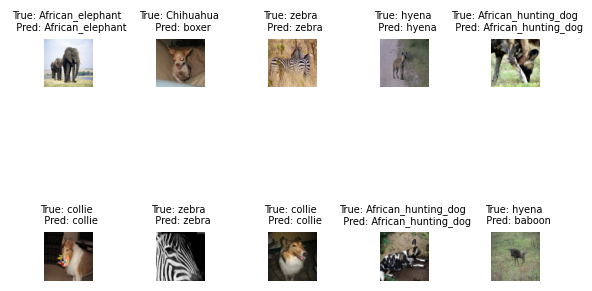

In [6]:
import random
import matplotlib.pyplot as plt
#{173: 10, 137: 1, 34: 5, 159: 3, 201: 4, 202: 11, 80: 7, 135: 8, 24: 9, 130: 12, 124: 13, 125: 14}
op_map={
    173: 'Chihuahua',
    137: 'baboon',
    34: 'hyena',
    159: 'Arctic_fox',
    201: 'lynx',
    202: 'African_hunting_dog',
    80: 'zebra',
    135: 'patas',
    24: 'African_elephant',
    130: 'boxer',
    124: 'collie',
    125: 'golden_retriever'
}

rever_map={
    10: 173, 
    1: 137, 
    5: 34, 
    3: 159, 
    4: 201, 
    11: 202, 
    7: 80, 
    8: 135, 
    9: 24, 
    12: 130, 
    13: 124, 
    14: 125
}

def display_sample(test_set, classifier_list, filter_list, device, display_num=10):
    random.seed(72)
    rd_list = [i for i in range(len(test_set))]
    random.shuffle(rd_list)
    sample_list = rd_list[:display_num]
    print(f'index of the sample displayed {sample_list}')
    
    display_samples = []
    for i in sample_list:
        image, label = test_set[i]
        image = image.unsqueeze(0).to(device)  
        output = merged_model(image, classifier_list, filter_list) 
        display_samples.append((image.squeeze().cpu(), op_map[rever_map[label.item()]], op_map[rever_map[output]]))
    
    print(f'Displaying {display_num} samples: ')
    for i, (img, true_label, pred_label) in enumerate(display_samples):
        plt.subplot(2, 5, i + 1)  
        

        img = img.permute(1, 2, 0) 

        img = img.to(torch.uint8) 
        
        plt.imshow(img.numpy()) 
        plt.title(f"True: {true_label} \n  Pred: {pred_label}", fontsize=7)
        plt.axis('off') 

    plt.subplots_adjust(wspace=1.3, hspace=0.1)
    plt.show()


display_sample(test_set, classifier_list, filter_list, device, display_num=10)
